In [11]:
from DataPreprocessing.python.Data import *

import pandas as pd
import numpy as np


## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# This is new, it will allow us to interact with
# 3d plots in the notebook
from mpl_toolkits.mplot3d import Axes3D


from sklearn.preprocessing import StandardScaler

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

import tensorflow as tf

In [170]:
W_init = tf.random_normal_initializer(mean=0, stddev=1.0)
b_init = tf.constant_initializer(1.0)
def SimpleNN(input_state_shape, name=''):
    inputs = tf.keras.layers.Input(shape=(input_state_shape,), name='A_input')
    x = tf.keras.layers.Dense(units=20, activation=tf.nn.relu, kernel_initializer=W_init, bias_initializer=b_init, name='A_l1')(inputs)
    x = tf.keras.layers.Dense(units=40, activation=tf.nn.relu, kernel_initializer=W_init, bias_initializer=b_init, name='A_l2')(x)
    x = tf.keras.layers.Dense(units=1, activation=tf.nn.tanh, kernel_initializer=W_init, bias_initializer=b_init, name='A_a')(x)
    x = tf.keras.layers.Lambda(lambda x: (x+1.0)/2)(x)
    #x = tf.keras.layers.Dense(units=1, activation=tf.nn.relu, kernel_initializer=W_init, bias_initializer=b_init, name='A_last')(x)
    return tf.keras.models.Model(inputs=inputs, outputs=x, name='Actor' + name)

In [165]:
rootData = Data("/Users/czkaiweb/Research/ErdosBootCamp/Project/ProjectData/Root_Insurance_data.csv")
rootData.loadData()
rootData.factorizeData()
rootData.splitData(fraction=[0.5,0.3,0.2],random_seed=42)
data_train = rootData.getTrainDataCopy()
data_validation = rootData.getValidationDataCopy()
data_test  = rootData.getTestDataCopy()

X_train = data_train.iloc[:, 0:4].values
y_train = data_train.iloc[:, -1].values

X_validation = data_validation.iloc[:, 0:4].values
y_validation = data_validation.iloc[:, -1].values

X_test = data_test.iloc[:, 0:4].values
y_test = data_test.iloc[:, -1].values


sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_validation = sc.transform(X_validation)
X_test = sc.transform(X_test)

In [78]:
X_train

array([[-1.26363794, -1.1963683 , -1.01085896,  1.04333826],
       [-1.26363794,  1.28726945,  0.9892577 , -0.95846193],
       [-0.03370029,  0.04545057,  0.9892577 , -0.95846193],
       ...,
       [-0.03370029,  0.04545057,  0.9892577 ,  1.04333826],
       [-0.03370029,  0.04545057, -1.01085896,  1.04333826],
       [-1.26363794,  0.04545057,  0.9892577 ,  1.04333826]])

In [173]:

model_simpleNN = SimpleNN(4)
model_simpleNN.compile(optimizer="sgd", loss="mse",metrics=[tf.keras.metrics.AUC()])
model_simpleNN.fit(X_train,y_train,epochs=10)

Epoch 1/10
157/157 [==============================] - 0s 795us/step - loss: 0.7433 - auc_56: 0.5412
Epoch 2/10
157/157 [==============================] - 0s 750us/step - loss: 0.6883 - auc_56: 0.5479
Epoch 3/10
157/157 [==============================] - 0s 761us/step - loss: 0.6417 - auc_56: 0.5437
Epoch 4/10
157/157 [==============================] - 0s 720us/step - loss: 0.5362 - auc_56: 0.5763
Epoch 5/10
157/157 [==============================] - 0s 738us/step - loss: 0.4329 - auc_56: 0.6066
Epoch 6/10
157/157 [==============================] - 0s 756us/step - loss: 0.3831 - auc_56: 0.6194
Epoch 7/10
157/157 [==============================] - 0s 739us/step - loss: 0.3830 - auc_56: 0.6193
Epoch 8/10
157/157 [==============================] - 0s 730us/step - loss: 0.3830 - auc_56: 0.6195
Epoch 9/10
157/157 [==============================] - 0s 742us/step - loss: 0.3830 - auc_56: 0.6195
Epoch 10/10
157/157 [==============================] - 0s 742us/step - loss: 0.3830 - auc_56: 0.6195

In [174]:
y_vpred = model_simpleNN.predict(X_validation)
y_vpred.max()

1.0

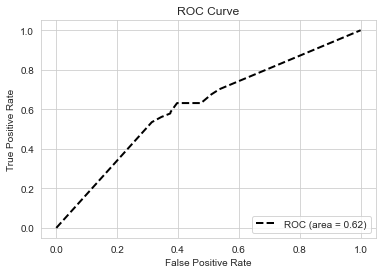

In [175]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_validation, y_vpred, pos_label=1)
roc_auc = auc(fpr, tpr)
 
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
 
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [17]:
def getReward(regressor, threshold, Xs, ys):
    reward = 0
    for index,X in enumerate(Xs):
        if regressor.predict(X.reshape(1,-1)) > threshold and ys[index] == 1 :
            reward += 130
        elif regressor.predict(X.reshape(1,-1)) > threshold and ys[index] == 0 :
            reward += -10
    return reward
            

In [176]:
reward_buffer = []
for threshold in thresholds:
    reward = getReward(model_simpleNN,threshold,X_validation,y_validation)
    reward_buffer.append(reward)
    
reward_buffer

[0, 0, 3530, 3530, 3500, 3790, 3790, 3790, 3790, 3310, 3310, 2770, 2950, 2970]

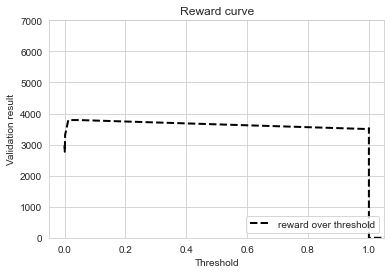

best_threshold = 0.048856109380722046


In [177]:
plt.plot(thresholds, reward_buffer, 'k--', label='reward over threshold', lw=2)
 
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 7000])
plt.xlabel('Threshold')
plt.ylabel('Validation result')
plt.title('Reward curve')
plt.legend(loc="lower right")
plt.show()

i_best_threshold = reward_buffer.index(max(reward_buffer))
best_threshold  = thresholds[i_best_threshold]
print("best_threshold = {}".format(best_threshold))

In [179]:
reward = getReward(model_simpleNN,best_threshold,X_test,y_test)
print("reward = {}".format(reward))
reward_naive = getReward(model_simpleNN,0,X_test,y_test)
print("naive reward = {}".format(reward_naive))

reward = 12210
naive reward = 11740
